In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import eli5
import xarray as xr
from eli5.sklearn import PermutationImportance
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

Dans ce projet il faut distinguer deux manières de voir les choses :
- pour avoir le meilleur score possible sur kaggle on veut que notre jeu d'entrainement soit proche du jeu de données test sur lequel on va baser nos soumissions
- pour pouvoir faire tourner notre modèle sur une requête au hasard, il faut que notre jeu d'entrainement soit le plus fourni possible

Pour ces deux objectifs nous réalisons les étapes suivantes :
- Analyser notre jeu de données
- Tester deux façons d'encoder (OneHotEncoder, target encoding) et deux modèles (random forest et XGBoost).
- On va analyser les features importantes 

Ensuite on va essayer d'améliorer notre modèle en :
- entrainer notre modèle seulement sur les features importantes
- Pour le défi kaggle : comparer notre dataset a celui du jeu de test et essayer de modifier notre dataset pour le rendre proche du test et retirer les features qui ne sont pas importantes

# Etude des données brutes

In [30]:
import os 
path = os.getcwd()
file = path+'/travail_continu/pricing_requests/pricing_requests_tot.csv'
dataset = pd.DataFrame(pd.read_csv(file))
dataset_brut = pd.DataFrame(pd.read_csv(file))
del dataset['Unnamed: 0']
del dataset_brut['Unnamed: 0']

In [9]:
dataset

,hotel_id,price,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,336,23,amsterdam,14,dutch,0,59852,Morriott International,Corlton,1,1,0
1,442,190,19,amsterdam,14,dutch,0,59852,Accar Hotels,Marcure,0,0,0
2,588,173,0,amsterdam,14,dutch,0,59852,Independant,Independant,0,0,0
3,807,323,17,amsterdam,14,dutch,0,59852,Chillton Worldwide,Chill Garden Inn,0,1,0
4,271,81,0,amsterdam,14,dutch,0,59852,Independant,Independant,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277212,230,167,6,amsterdam,13,swedish,1,319183,Boss Western,Boss Western,1,0,0
277213,548,253,41,amsterdam,13,swedish,1,319183,Morriott International,Corlton,0,1,0
277214,916,149,10,amsterdam,13,swedish,1,319183,Boss Western,Boss Western,1,0,0
277215,835,114,36,amsterdam,13,swedish,1,319183,Independant,Independant,0,0,0


<AxesSubplot:>

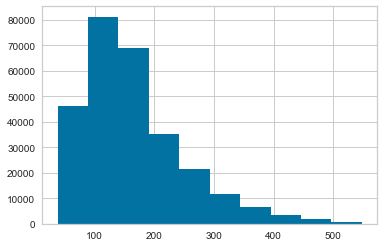

In [10]:
#on trace la distribution de la cible
dataset['price'].hist()

(array([47637., 36776., 30195., 37907., 30040., 18933., 22110., 16479.,
        15629., 21511.]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <BarContainer object of 10 artists>)

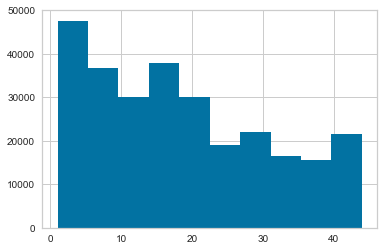

In [11]:
plt.hist(dataset['date'])

In [12]:
# langue :
langues = dataset.groupby(['language'])['language'].count()
nom = langues.index
nbe= langues.values
# langues = pd.DataFrame(langues)
# langues['language'§]
df = pd.DataFrame({

    'langue': nom,

    'value': nbe,


})
df.sort_values(by=['value'],ascending=False)

,langue,value
10,french,43501
2,bulgarian,14862
0,austrian,14345
19,maltese,13248
22,romanian,13073
20,polish,13030
25,spanish,12857
26,swedish,12783
7,dutch,11318
24,slovene,11138


In [13]:
villes = dataset.groupby(['city'])['city'].count()
nom = villes.index
nbe= villes.values
# langues = pd.DataFrame(langues)
# langues['language']
df = pd.DataFrame({

    'ville': nom,

    'value': nbe,

})
df.sort_values(by=['value'],ascending=False)

,ville,value
3,paris,51777
0,amsterdam,44489
2,madrid,38656
1,copenhagen,36229
4,rome,31550
7,vienna,27206
8,vilnius,22630
5,sofia,13361
6,valletta,11319


array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='stock', ylabel='price'>,
        <AxesSubplot:xlabel='date', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='stock'>,
        <AxesSubplot:xlabel='stock', ylabel='stock'>,
        <AxesSubplot:xlabel='date', ylabel='stock'>],
       [<AxesSubplot:xlabel='price', ylabel='date'>,
        <AxesSubplot:xlabel='stock', ylabel='date'>,
        <AxesSubplot:xlabel='date', ylabel='date'>]], dtype=object)

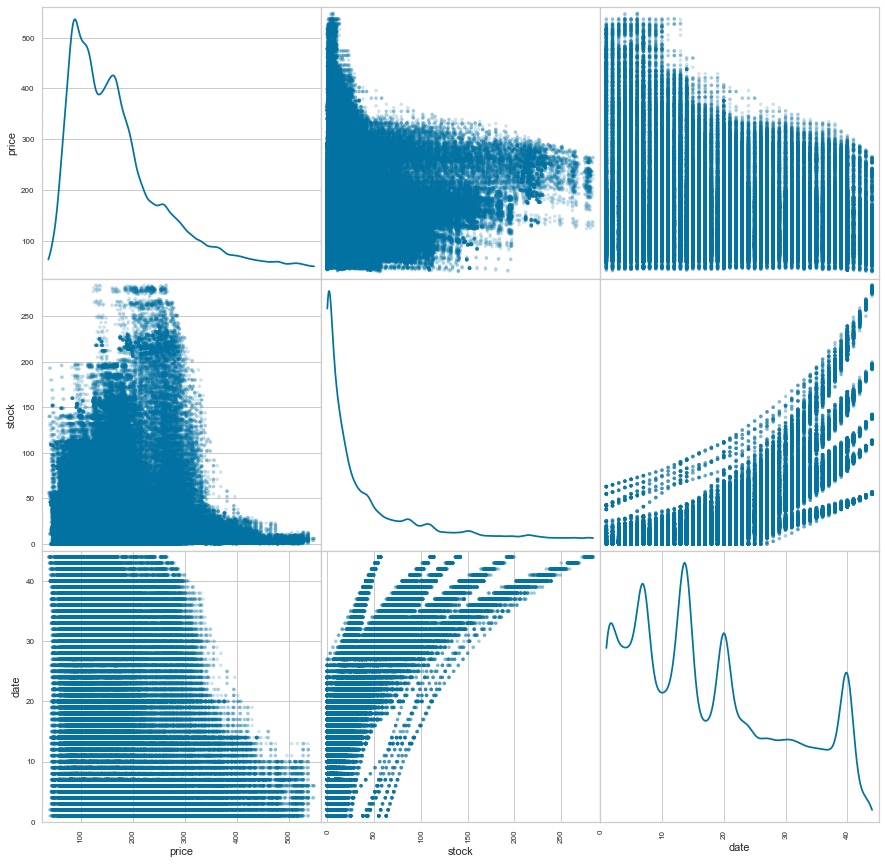

In [14]:
scatter_matrix(dataset[["price","stock","date"]], alpha=0.2, figsize=(15, 15), diagonal='kde')

# Préparation des données
Dans cette partie on transforme les variables qualitatives en les encodant de plusieurs manières différentes : avec One Hot Encoder, avec Target Encoder et avec Target encoder avec additive smoothing.

Encodage avec OneHotEncoder


L'encodage one-hot ou encodage 1-parmi-n consiste à encoder une variable à n états sur n bits dons un seul prend la valeur 1, le numéro du bit valant 1 étant le numéro de l'état pris par la variable.

source : https://fr.wikipedia.org/wiki/Encodage_one-hot

### encodage avec OneHotEncoder

In [15]:
dataset

,hotel_id,price,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,336,23,amsterdam,14,dutch,0,59852,Morriott International,Corlton,1,1,0
1,442,190,19,amsterdam,14,dutch,0,59852,Accar Hotels,Marcure,0,0,0
2,588,173,0,amsterdam,14,dutch,0,59852,Independant,Independant,0,0,0
3,807,323,17,amsterdam,14,dutch,0,59852,Chillton Worldwide,Chill Garden Inn,0,1,0
4,271,81,0,amsterdam,14,dutch,0,59852,Independant,Independant,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277212,230,167,6,amsterdam,13,swedish,1,319183,Boss Western,Boss Western,1,0,0
277213,548,253,41,amsterdam,13,swedish,1,319183,Morriott International,Corlton,0,1,0
277214,916,149,10,amsterdam,13,swedish,1,319183,Boss Western,Boss Western,1,0,0
277215,835,114,36,amsterdam,13,swedish,1,319183,Independant,Independant,0,0,0


In [16]:
# Variables explicatives

from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc_data=pd.DataFrame(enc.fit_transform(dataset[["city","language","group","brand"]]).toarray())
df_ohe=dataset.join(enc_data)
one_hot_encoded_data = pd.get_dummies(dataset, columns = ["city","language","group","brand"])

X_ohe = one_hot_encoded_data.drop(labels='price',axis=1)
Y_ohe = one_hot_encoded_data.price
X_ohe

,hotel_id,stock,date,mobile,avatar_id,parking,pool,children_policy,city_amsterdam,city_copenhagen,...,brand_Ibas,brand_Independant,brand_J.Halliday Inn,brand_Marcure,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree
0,918,23,14,0,59852,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,442,19,14,0,59852,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,588,0,14,0,59852,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,807,17,14,0,59852,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,271,0,14,0,59852,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277212,230,6,13,1,319183,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
277213,548,41,13,1,319183,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
277214,916,10,13,1,319183,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
277215,835,36,13,1,319183,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


### encodage avec Target Encoder


In [18]:
dict_city =  dataset.groupby('city')['price'].mean().to_dict()
dict_language = dataset.groupby('language')['price'].mean().to_dict()
dict_brand = dataset.groupby('brand')['price'].mean().to_dict()
dict_group = dataset.groupby('group')['price'].mean().to_dict()

In [20]:
from category_encoders.target_encoder import TargetEncoder
encoder = TargetEncoder()

/opt/anaconda3/envs/IA/lib/python3.7/site-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/opt/anaconda3/envs/IA/lib/python3.7/site-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [25]:
dataset_targ = dataset.copy()

In [26]:
dataset_targ['city']=encoder.fit_transform(dataset_targ['city'],dataset_targ['price'])
dataset_targ['language']=encoder.fit_transform(dataset_targ['language'],dataset_targ['price'])
dataset_targ['brand']=encoder.fit_transform(dataset_targ['brand'],dataset_targ['price'])
dataset_targ['group']=encoder.fit_transform(dataset_targ['group'],dataset_targ['price'])

In [27]:
X_target = dataset_targ.drop(labels='price',axis=1)
Y_target = dataset_targ.price

In [28]:
X_target

,hotel_id,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,23,175.159702,14,180.985068,0,59852,233.131209,298.373114,1,1,0
1,442,19,175.159702,14,180.985068,0,59852,196.765401,204.990063,0,0,0
2,588,0,175.159702,14,180.985068,0,59852,100.087631,100.087631,0,0,0
3,807,17,175.159702,14,180.985068,0,59852,228.717923,307.429005,0,1,0
4,271,0,175.159702,14,180.985068,0,59852,100.087631,100.087631,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
277212,230,6,175.159702,13,172.262693,1,319183,139.661765,127.477378,1,0,0
277213,548,41,175.159702,13,172.262693,1,319183,233.131209,298.373114,0,1,0
277214,916,10,175.159702,13,172.262693,1,319183,139.661765,127.477378,1,0,0
277215,835,36,175.159702,13,172.262693,1,319183,100.087631,100.087631,0,0,0


##### Target encoding avec Additive smoothing

In [31]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [32]:
dataset_smooth=dataset.copy()

In [33]:
m=300
dataset_smooth['city']=calc_smooth_mean(dataset_smooth,'city','price',m=m)
dataset_smooth['language']=calc_smooth_mean(dataset_smooth,'language','price',m=m)
dataset_smooth['brand']=calc_smooth_mean(dataset_smooth,'brand','price',m=m)
dataset_smooth['group']=calc_smooth_mean(dataset_smooth,'group','price',m=m)

In [34]:
dataset_smooth

,hotel_id,price,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,336,23,175.091366,14,180.571198,0,59852,232.566778,295.730868,1,1,0
1,442,190,19,175.091366,14,180.571198,0,59852,196.587341,204.143585,0,0,0
2,588,173,0,175.091366,14,180.571198,0,59852,100.368988,100.368988,0,0,0
3,807,323,17,175.091366,14,180.571198,0,59852,228.065618,303.236605,0,1,0
4,271,81,0,175.091366,14,180.571198,0,59852,100.368988,100.368988,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277212,230,167,6,175.091366,13,172.095176,1,319183,139.827731,127.924970,1,0,0
277213,548,253,41,175.091366,13,172.095176,1,319183,232.566778,295.730868,0,1,0
277214,916,149,10,175.091366,13,172.095176,1,319183,139.827731,127.924970,1,0,0
277215,835,114,36,175.091366,13,172.095176,1,319183,100.368988,100.368988,0,0,0


In [35]:
X_smooth = dataset_smooth.drop(labels='price',axis=1)
Y_smooth = dataset_smooth.price

In [36]:
X_smooth

,hotel_id,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,23,175.091366,14,180.571198,0,59852,232.566778,295.730868,1,1,0
1,442,19,175.091366,14,180.571198,0,59852,196.587341,204.143585,0,0,0
2,588,0,175.091366,14,180.571198,0,59852,100.368988,100.368988,0,0,0
3,807,17,175.091366,14,180.571198,0,59852,228.065618,303.236605,0,1,0
4,271,0,175.091366,14,180.571198,0,59852,100.368988,100.368988,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
277212,230,6,175.091366,13,172.095176,1,319183,139.827731,127.924970,1,0,0
277213,548,41,175.091366,13,172.095176,1,319183,232.566778,295.730868,0,1,0
277214,916,10,175.091366,13,172.095176,1,319183,139.827731,127.924970,1,0,0
277215,835,36,175.091366,13,172.095176,1,319183,100.368988,100.368988,0,0,0


# Modèle

### Extraction des échantillons apprentissage et test

In [37]:
# Avec l'encodage OneHotEncoding
from sklearn.model_selection import train_test_split  
X_train_ohe,X_test_ohe,Y_train_ohe,Y_test_ohe=train_test_split(X_ohe,Y_ohe,test_size=0.1)

In [38]:
# Avec l'encodage Target Encoding
from sklearn.model_selection import train_test_split  
X_train_target,X_test_target,Y_train_target,Y_test_target=train_test_split(X_target,Y_target,test_size=0.1)

In [39]:
# Avec l'encodage Additive smoothing
from sklearn.model_selection import train_test_split  
X_train_smooth,X_test_smooth,Y_train_smooth,Y_test_smooth=train_test_split(X_smooth,Y_smooth,test_size=0.1)

### Modèle random forest

In [40]:
rf_ohe = RandomForestRegressor(max_depth=10)
rf_target = RandomForestRegressor(max_depth=10)
rf_smooth = RandomForestRegressor(max_depth=10)

On entraine notre modèle sur l'ensemble de la base de données 

In [41]:
rf_ohe.fit(X_train_ohe, Y_train_ohe)

RandomForestRegressor(max_depth=10)

In [42]:
rf_target.fit(X_train_target, Y_train_target)

RandomForestRegressor(max_depth=10)

In [43]:
rf_smooth.fit(X_train_smooth, Y_train_smooth)

RandomForestRegressor(max_depth=10)

In [44]:
print(f"Random forest score: {rf_ohe.score(X_test_ohe, Y_test_ohe):.2f}")
print(f"Random forest score: {rf_target.score(X_test_target, Y_test_target):.2f}")
print(f"Random forest score: {rf_smooth.score(X_test_smooth, Y_test_smooth):.2f}")

Random forest score: 0.89
Random forest score: 0.97
Random forest score: 0.97


L'encodage en target encoding a nettement amélioré le score par rapport à One Hot Encoding. Cependant, avec target encoding, nous faisons de l'overfitting.

In [45]:
pred_ohe = rf_ohe.predict(X_test_ohe)
pred_target = rf_target.predict(X_test_target)
pred_smooth = rf_target.predict(X_test_smooth)

In [46]:
rmse_ohe = np.sqrt(MSE(Y_test_ohe, pred_ohe))
rmse_target = np.sqrt(MSE(Y_test_target, pred_target))
rmse_smooth = np.sqrt(MSE(Y_test_smooth, pred_smooth))
print("RMSE (ohe) : % f" %(rmse_ohe))
print("RMSE (target) : % f" %(rmse_target))
print("RMSE (smooth) : % f" %(rmse_smooth))

RMSE (ohe) :  27.880573
RMSE (target) :  15.323471
RMSE (smooth) :  15.354203


RMSE avec target encoding est inférieur à celui avec One Hot Encoding

In [51]:
mse_ohe = MSE(Y_test_ohe, pred_ohe)
RMSE_ohe = np.sqrt(mse_ohe)

R_squared_ohe = r2_score(Y_test_ohe, pred_ohe)

mse_target = MSE(Y_test_target, pred_target)
RMSE_target = np.sqrt(mse_target)

R_squared_target = r2_score(Y_test_target, pred_target)

mse_smooth = MSE(Y_test_smooth, pred_smooth)
RMSE_smooth = np.sqrt(mse_smooth)

R_squared_smooth = r2_score(Y_test_smooth, pred_smooth)

Random forest avec One Hot Encoding

RMSE:  27.88

R-Squared:  0.89

Prediction Error Plot


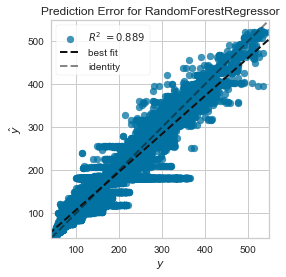

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=RandomForestRegressor(max_depth=10))


In [52]:
print('Random forest avec One Hot Encoding')
print("\nRMSE: ", np.round(RMSE_ohe, 2))
print()
print("R-Squared: ", np.round(R_squared_ohe, 2))

# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(rf_ohe, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe))

# # Making the Residuals Plot
# print("\nResiduals Plot")
# print(residuals_plot(rf_ohe, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe))

Random forest avec target encoding

RMSE:  15.35

R-Squared:  0.97

Prediction Error Plot


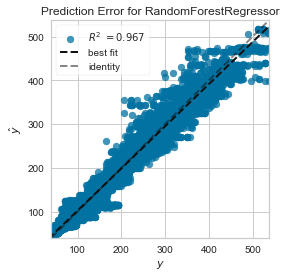

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=RandomForestRegressor(max_depth=10))


In [49]:
print('Random forest avec target encoding')
print("\nRMSE: ", np.round(RMSE_target, 2))
print()
print("R-Squared: ", np.round(R_squared_target, 2))

# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(rf_target, X_train_target, Y_train_target, X_test_target, Y_test_target))

# # Making the Residuals Plot
# print("\nResiduals Plot")
# print(residuals_plot(rf_target, X_train_target, Y_train_target, X_test_target, Y_test_target))

Random forest avec Target encoding et additive smoothing

RMSE:  15.35

R-Squared:  0.97

Prediction Error Plot


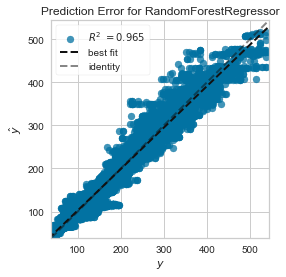

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=RandomForestRegressor(max_depth=10))


In [54]:
print('Random forest avec Target encoding et additive smoothing')
print("\nRMSE: ", np.round(RMSE_smooth, 2))
print()
print("R-Squared: ", np.round(R_squared_smooth, 2))

# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(rf_smooth, X_train_smooth, Y_train_smooth, X_test_smooth, Y_test_smooth))

# # Making the Residuals Plot
# print("\nResiduals Plot")
# print(residuals_plot(rf_ohe, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe))

On a également amélioré la valeur R2 avec target encoding

### Modèle XGBoost

In [55]:
from xgboost import XGBRegressor
xgb_ohe = XGBRegressor()
xgb_target = XGBRegressor()
xgb_smooth = XGBRegressor()

On entraine notre modèle sur l'ensemble de la base de données

In [58]:
xgb_ohe.fit(X_train_ohe,Y_train_ohe)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [59]:
xgb_target.fit(X_train_target,Y_train_target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [60]:
xgb_smooth.fit(X_train_smooth,Y_train_smooth)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [61]:
print(f"XGBoost score: {xgb_ohe.score(X_test_ohe, Y_test_ohe):.2f}")
print(f"XGBoost score: {xgb_target.score(X_test_target, Y_test_target):.2f}")
print(f"XGBoost score: {xgb_smooth.score(X_test_smooth, Y_test_smooth):.2f}")

XGBoost score: 0.98
XGBoost score: 0.99
XGBoost score: 0.99


Encore une fois le score est amélioré avec target encoding même si la différence est légère. 

In [62]:
pred_ohe = xgb_ohe.predict(X_test_ohe)
pred_target = xgb_target.predict(X_test_target)
pred_smooth = xgb_smooth.predict(X_test_smooth)

In [63]:
rmse_ohe = np.sqrt(MSE(Y_test_ohe, pred_ohe))
rmse_target = np.sqrt(MSE(Y_test_target, pred_target))
rmse_smooth = np.sqrt(MSE(Y_test_smooth, pred_smooth))
print("RMSE (ohe) : % f" %(rmse_ohe))
print("RMSE (target) : % f" %(rmse_target))
print("RMSE (smooth) : % f" %(rmse_smooth))

RMSE (ohe) :  11.001243
RMSE (target) :  9.043904
RMSE (smooth) :  9.214785


RMSE avec target est plus faible qu'avec one hot encoder

In [64]:
mse_ohe = MSE(Y_test_ohe, pred_ohe)
RMSE_ohe = np.sqrt(mse_ohe)

R_squared_ohe = r2_score(Y_test_ohe, pred_ohe)

mse_target = MSE(Y_test_target, pred_target)
RMSE_target = np.sqrt(mse_target)

R_squared_target = r2_score(Y_test_target, pred_target)

mse_smooth = MSE(Y_test_smooth, pred_smooth)
RMSE_smooth = np.sqrt(mse_smooth)

R_squared_smooth = r2_score(Y_test_smooth, pred_smooth)

XGBoost avec One Hot Encoding

RMSE:  11.2

R-Squared:  0.98

Prediction Error Plot


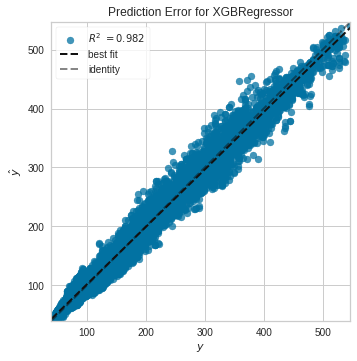

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.300000012, max_bin=256,
                                       max_cat_threshold=64,
                                       max_cat_to_

In [37]:
print('XGBoost avec One Hot Encoding')
print("\nRMSE: ", np.round(RMSE_ohe, 2))
print()
print("R-Squared: ", np.round(R_squared_ohe, 2))

# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xgb_ohe, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe))

# # Making the Residuals Plot
# print("\nResiduals Plot")
# print(residuals_plot(xgb_ohe, X_train_ohe, Y_train_ohe, X_test_ohe, Y_test_ohe))

XGBoost avec target encoding

RMSE:  9.58

R-Squared:  0.99

Prediction Error Plot


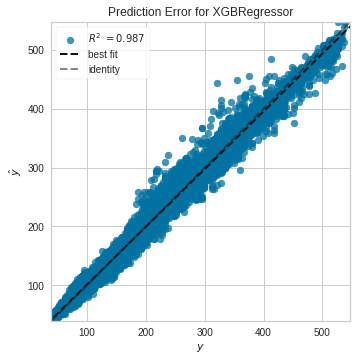

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.300000012, max_bin=256,
                                       max_cat_threshold=64,
                                       max_cat_to_

In [38]:
print('XGBoost avec target encoding')
print("\nRMSE: ", np.round(RMSE_target, 2))
print()
print("R-Squared: ", np.round(R_squared_target, 2))

# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xgb_target, X_train_target, Y_train_target, X_test_target, Y_test_target))

# # Making the Residuals Plot
# print("\nResiduals Plot")
# print(residuals_plot(xgb_target, X_train_target, Y_train_target, X_test_target, Y_test_target))

XGBoost avec target encoding et additive smoothing

RMSE:  9.21

R-Squared:  0.99

Prediction Error Plot


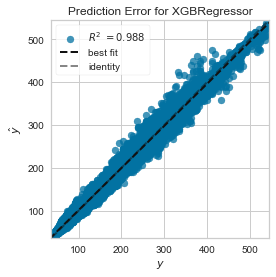

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1,
                                       enable_categorical=False, gamma=0,
                                       gpu_id=-1, importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=6,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=4,
                                       num_parallel_tree=1, predictor='auto',
                                  

In [65]:
print('XGBoost avec target encoding et additive smoothing')
print("\nRMSE: ", np.round(RMSE_smooth, 2))
print()
print("R-Squared: ", np.round(R_squared_smooth, 2))

# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xgb_smooth, X_train_smooth, Y_train_smooth, X_test_smooth, Y_test_smooth))

# # Making the Residuals Plot
# print("\nResiduals Plot")
# print(residuals_plot(xgb_target, X_train_target, Y_train_target, X_test_target, Y_test_target))

Les scores obtenus avec target encoding + xgboost sont meilleurs qu'avec random forest. Ainsi, nous allons choisir cette manière d'encoder et ce modèle pour construire notre application gradio et pour nos soumissions kaggle.

### Feature Importance

On trace les features par ordre d'importance pour les deux modèles testés (random forest et XGBoost) avec les deux façons d'encoder.

In [67]:
feature_names_ohe = list(X_ohe.columns.values) #si OneHotEncoder
feature_names_target = list(X_target.columns.values) #si Target encoding
feature_names_smooth = list(X_smooth.columns.values)

Feature importances si on a encodé avec ohe

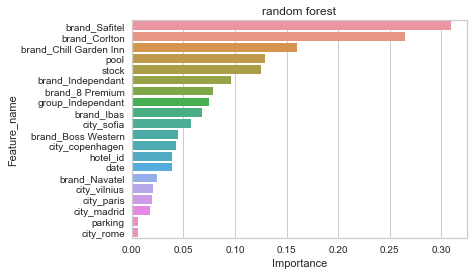

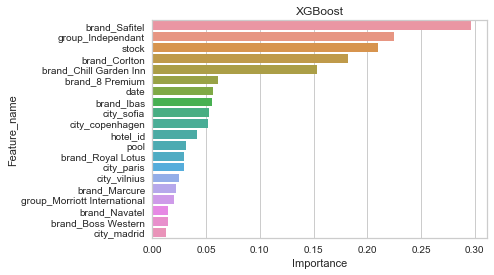

In [68]:
import seaborn as sns

features_importance_dict = {}
for model, name in zip([rf_ohe,xgb_ohe], ['random forest','XGBoost']):
    plt.figure()
    permumtation_impor = PermutationImportance(model, random_state=0).fit(X_test_ohe, Y_test_ohe)
    features_importance = {'Feature_name':feature_names_ohe, 'Importance':permumtation_impor.feature_importances_}  
    features_importance = pd.DataFrame(features_importance) 
    features_importance = features_importance.sort_values(['Importance'], ascending=False) 
    features_importance_dict[name] = features_importance
    ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance[0:20])
    plt.title(name)

On regroupe les features par catégories  (si on a encoder avec ohe)

In [69]:
features_importance_dict['random forest']
Feature_name = features_importance_dict['random forest']['Feature_name'].tolist()
Importance = features_importance_dict['random forest']['Importance'].tolist()

Feature_name2 = ['city','language', 'group','brand','hotel_id','stock','date','mobile','avatar_id','parking','pool','children_policy']
Importance2 = [0 for i in range(len(Feature_name2))]

for i in range(len(Feature_name)):
    if Feature_name[i][0:4]=='city':
        Importance2[0]=Importance2[0]+Importance[i]
    
    if Feature_name[i][0:8]=='language':
        Importance2[1]=Importance2[1]+Importance[i]  
   
    if Feature_name[i][0:5]=='group':
        Importance2[2]=Importance2[2]+Importance[i]  
        
    if Feature_name[i][0:5]=='brand':
        Importance2[3]=Importance2[3]+Importance[i]  

for j in range(4,len(Feature_name2)):
    Importance2[j]= Importance[Feature_name.index(Feature_name2[j])]     
        
Importance2      
features_importance2 = pd.DataFrame(list(zip(Feature_name2, Importance2)),columns =['Feature_name2', 'Importance2'])
features_importance2


,Feature_name2,Importance2
0,city,0.166983
1,language,0.000290
2,group,0.075358
3,brand,1.047242
4,hotel_id,0.039410
5,stock,0.125430
6,date,0.039398
7,mobile,0.000006
8,avatar_id,0.000011
9,parking,0.006005


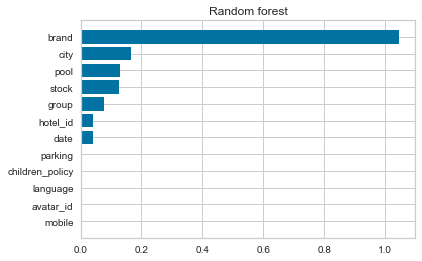

In [70]:
# Create a data frame
df = pd.DataFrame ({
        'Group':  features_importance2['Feature_name2'],
        'Value': features_importance2['Importance2']
})

# Sort the table
df = df.sort_values(by=['Value'])

# Create horizontal bars
plt.barh(y=df.Group, width=df.Value);

# Add title
plt.title('Random forest');

Parking, language, children_policy, avatar_id, mobile n'ont pas d'importance 

In [71]:
features_importance_dict['XGBoost']
Feature_name = features_importance_dict['XGBoost']['Feature_name'].tolist()
Importance_xgb = features_importance_dict['XGBoost']['Importance'].tolist()

Feature_name2 = ['city','language', 'group','brand','hotel_id','stock','date','mobile','avatar_id','parking','pool','children_policy']
Importance2_xgb = [0 for i in range(len(Feature_name2))]

for i in range(len(Feature_name)):
    if Feature_name[i][0:4]=='city':
        Importance2_xgb[0]=Importance2_xgb[0]+Importance_xgb[i]
    
    if Feature_name[i][0:8]=='language':
        Importance2_xgb[1]=Importance2_xgb[1]+Importance_xgb[i]  
   
    if Feature_name[i][0:5]=='group':
        Importance2_xgb[2]=Importance2_xgb[2]+Importance_xgb[i]  
        
    if Feature_name[i][0:5]=='brand':
        Importance2_xgb[3]=Importance2_xgb[3]+Importance_xgb[i]  

for j in range(4,len(Feature_name2)):
    Importance2_xgb[j]= Importance_xgb[Feature_name.index(Feature_name2[j])]     
        
Importance2_xgb   
features_importance2 = pd.DataFrame(list(zip(Feature_name2, Importance2_xgb)),columns =['Feature_name2', 'Importance2_xgb'])
features_importance2


,Feature_name2,Importance2_xgb
0,city,0.181478
1,language,0.006208
2,group,0.256430
3,brand,0.850397
4,hotel_id,0.041539
5,stock,0.210054
6,date,0.056720
7,mobile,0.000029
8,avatar_id,0.000732
9,parking,0.003006


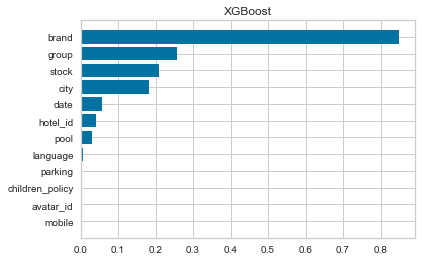

In [72]:
# Create a data frame
df = pd.DataFrame ({
        'Group':  features_importance2['Feature_name2'],
        'Value': features_importance2['Importance2_xgb']
})

# Sort the table
df = df.sort_values(by=['Value'])

# Create horizontal bars
plt.barh(y=df.Group, width=df.Value);

# Add title
plt.title('XGBoost');

De même, Parking, language, children_policy, avatar_id, mobile n'ont pas d'importance 

Features importance avec les target encoding

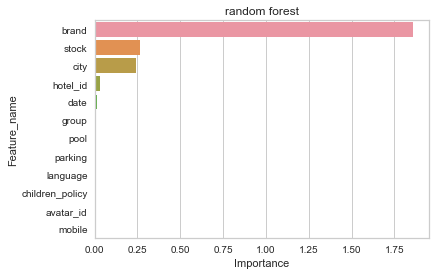

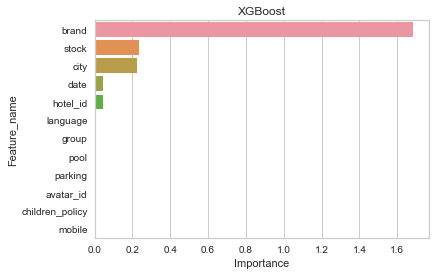

In [73]:
import seaborn as sns

features_importance_dict = {}
for model, name in zip([rf_target,xgb_target], ['random forest','XGBoost']):
    plt.figure()
    permumtation_impor = PermutationImportance(model, random_state=0).fit(X_test_target, Y_test_target)
    features_importance = {'Feature_name':feature_names_target, 'Importance':permumtation_impor.feature_importances_}  
    features_importance = pd.DataFrame(features_importance) 
    features_importance = features_importance.sort_values(['Importance'], ascending=False) 
    features_importance_dict[name] = features_importance
    ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance[0:20])
    plt.title(name)

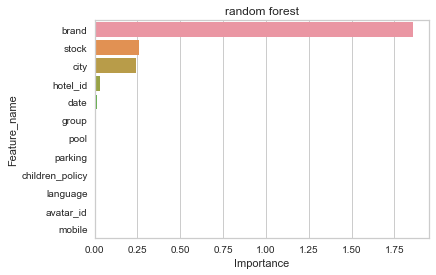

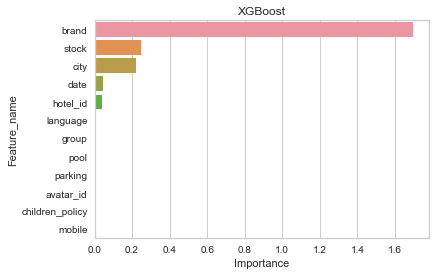

In [74]:
import seaborn as sns

features_importance_dict = {}
for model, name in zip([rf_smooth,xgb_smooth], ['random forest','XGBoost']):
    plt.figure()
    permumtation_impor = PermutationImportance(model, random_state=0).fit(X_test_smooth, Y_test_smooth)
    features_importance = {'Feature_name':feature_names_smooth, 'Importance':permumtation_impor.feature_importances_}  
    features_importance = pd.DataFrame(features_importance) 
    features_importance = features_importance.sort_values(['Importance'], ascending=False) 
    features_importance_dict[name] = features_importance
    ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance[0:20])
    plt.title(name)

Avec cette méthode on voit que seules brand, stock, city, date et hotel_id ont une importance. Dans le modèle qu'on va créer (voir gradio) on va retirer les autres features pour l'apprentissage

# Amélioration du modèle

## 1. En sélectionnant les features 

On va essayer d'améliorer le modèle XGBoost encodé avec target encoding pour avoir une application gradio efficace. On retire les features qui ne sont pas importantes pour l'entrainement du modèle

In [111]:
xgb_target_improve = XGBRegressor()

In [112]:
X_train_target2 = X_train_target.copy()

In [113]:
del X_train_target2['mobile']
del X_train_target2['avatar_id']
del X_train_target2['parking']
del X_train_target2['group']
del X_train_target2['pool']
del X_train_target2['children_policy']

In [114]:
X_train_target2

,hotel_id,stock,city,date,language,brand
22032,384,4,147.682611,3,158.896892,204.990063
243142,441,6,175.159702,4,178.745417,208.650445
146178,667,110,113.692002,40,159.105607,154.340630
234395,155,1,113.692002,3,180.985068,127.477378
92937,436,19,198.058404,2,172.057933,305.573276
...,...,...,...,...,...,...
154207,787,78,152.089699,39,167.034682,127.477378
49593,842,8,198.058404,8,180.985068,305.573276
86883,986,150,198.058404,40,172.057933,214.518780
51295,947,113,152.089699,41,140.132310,165.882197


In [115]:
X_test_target2 = X_test_target.copy()
del X_test_target2['mobile']
del X_test_target2['avatar_id']
del X_test_target2['parking']
del X_test_target2['group']
del X_test_target2['pool']
del X_test_target2['children_policy']

In [116]:
xgb_target_improve.fit(X_train_target2,Y_train_target)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [117]:
print(f"XGBoost score: {xgb_target_improve.score(X_test_target2, Y_test_target):.2f}")

XGBoost score: 0.99


In [118]:
pred_target_improve = xgb_target_improve.predict(X_test_target2)
rmse_target_improve = np.sqrt(MSE(Y_test_target, pred_target_improve))
print("RMSE (target) : % f" %(rmse_target_improve))

RMSE (target) :  9.281825


On a le même score que précedemment mais un RSME un tout petit peu plus grand (au centième près). On va donc choisir un modèle qui s'entraine sur les features suivantes : hotel_id, stock,city, date, language et brand

## 2. En triant notre jeu de données en fonction du jeu données du test set (seulement pour l'objectif kaggle)

Lorsqu'on crée notre jeu de données, nous pouvons agir sur la ville, la langue, l'avatar, la date, le mobile. Nous allons ainsi regarder plus précisemment ces variables du test set afin d'agrandir notre jeu de données de façon ciblée.

In [76]:
# test sur le jeu de données test pour la soumission

path = os.getcwd()
file_test = path+'/test_set.csv'
hotel_features = pd.read_csv(path+'/features_hotels.csv',index_col=['hotel_id', 'city'])

dataset_test = pd.DataFrame(pd.read_csv(file_test,index_col=0))
X_dataset_test= dataset_test.drop(labels=['order_requests'], axis=1)
X_dataset_test = X_dataset_test.join(hotel_features, on=['hotel_id', 'city'])
X_dataset_test.head()

,city,date,language,mobile,avatar_id,hotel_id,stock,group,brand,parking,pool,children_policy
index,,,,,,,,,,,,
0,vilnius,21,romanian,0,1,161,46,Boss Western,J.Halliday Inn,1,0,0
1,vilnius,21,romanian,0,1,187,32,Accar Hotels,Marcure,1,1,0
2,vilnius,21,romanian,0,1,279,12,Independant,Independant,1,0,0
3,vilnius,21,romanian,0,1,395,10,Accar Hotels,Ibas,0,0,0
4,vilnius,21,romanian,0,1,488,42,Accar Hotels,Safitel,1,1,1


(array([1864., 1351.,    0.,  267., 1059.,  520.,    0.,    0.,  486.,
        1097.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

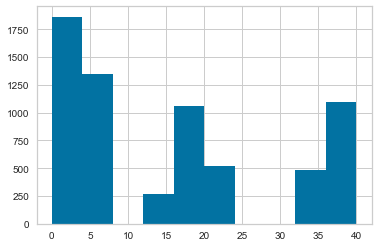

In [77]:
# Date :
plt.hist(X_dataset_test.date)

On remarque que les dates comprises entre J0 et J-7 sont majoritaires, nous avons également un certain nombre de "demandes" pour des dates entre J-12 et J-24 puis entre J-32 et J-40.

In [78]:
# langue :
langues = X_dataset_test.groupby(['language'])['language'].count()
nom = langues.index
nbe= langues.values
# langues = pd.DataFrame(langues)
# langues['language']
df = pd.DataFrame({

    'langue': nom,

    'value': nbe,


})
df.sort_values(by=['value'],ascending=False)


,langue,value
13,hungarian,967
9,finnish,466
0,austrian,461
22,romanian,439
23,slovakian,418
26,swedish,404
8,estonian,390
2,bulgarian,356
6,danish,346
14,irish,209


on se rend compte que certaines langues sont bien plus utilisées que d'autres. On va donc agrandir notre jeu de données en se concentrant sur ces langues ci : hungarian, finnish, austrian, romanian, slovakian, swedish, estonian, bulgarian et danish.


In [79]:
# ville :
villes = X_dataset_test.groupby(['city'])['city'].count()
nom = villes.index
nbe= villes.values
# langues = pd.DataFrame(langues)
# langues['language']
df = pd.DataFrame({

    'ville': nom,

    'value': nbe,

})
df.sort_values(by=['value'],ascending=False)

,ville,value
0,amsterdam,1134
3,paris,1125
2,madrid,1094
1,copenhagen,723
4,rome,721
8,vilnius,609
7,vienna,568
5,sofia,374
6,valletta,296


Les villes les plus représentées sont : Amsterdam, Paris et Madrid. On va donc concentrer nos requêtes sur ces villes pour fournir notre jeu de données.

(array([3630.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3014.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

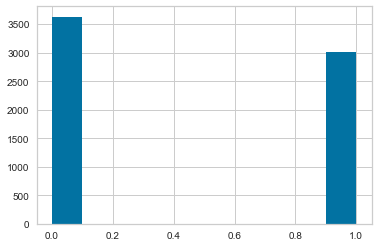

In [80]:
#mobile
plt.hist(X_dataset_test.mobile)

La différence entre le téléphone et l'ordinateur n'est pas très grande, on peut continuer à choisir aléatoirement

In [84]:
path = os.getcwd()
file = path+'/travail_continu/pricing_requests/pricing_requests_tot.csv'
dataset = pd.DataFrame(pd.read_csv(file))
dataset_brut = pd.DataFrame(pd.read_csv(file))
del dataset['Unnamed: 0']
del dataset_brut['Unnamed: 0']

On essaye d'avoir un dataset proche de celui du test (voir plus loin). Pour cela, on commence par retirer du dataset les jours compris entre 8 et 12 et entre 24 et 32.


In [85]:
for i in range(8,13):
    dataset.drop(dataset[dataset.date == i].index, inplace=True)
for i in range(24,33):
    dataset.drop(dataset[dataset.date == i].index, inplace=True)

In [86]:
villes = dataset.groupby(['city'])['city'].count()
nom = villes.index
nbe= villes.values
# langues = pd.DataFrame(langues)
# langues['language']
df = pd.DataFrame({

    'ville': nom,

    'value': nbe,

})
df.sort_values(by=['value'],ascending=False)

,ville,value
3,paris,39732
0,amsterdam,35312
2,madrid,30768
1,copenhagen,25573
4,rome,21438
7,vienna,18726
8,vilnius,16492
5,sofia,9676
6,valletta,8007


(array([47637., 24528., 11237., 37907., 30040.,  5016.,     0., 12219.,
        15629., 21511.]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <BarContainer object of 10 artists>)

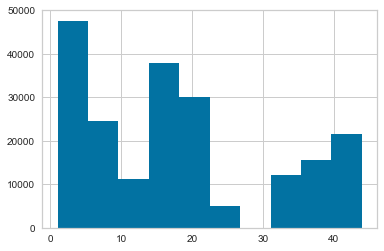

In [87]:
plt.hist(dataset['date'])

### Code pour la soumission

In [88]:
# test sur le jeu de données test pour la soumission
file_test = path+'/test_set.csv'
hotel_features = pd.read_csv(path+'/features_hotels.csv',index_col=['hotel_id', 'city'])

dataset_test = pd.DataFrame(pd.read_csv(file_test,index_col=0))
X_dataset_test= dataset_test.drop(labels=['order_requests'], axis=1)
X_dataset_test = X_dataset_test.join(hotel_features, on=['hotel_id', 'city'])

In [89]:
X_dataset_test

,city,date,language,mobile,avatar_id,hotel_id,stock,group,brand,parking,pool,children_policy
index,,,,,,,,,,,,
0,vilnius,21,romanian,0,1,161,46,Boss Western,J.Halliday Inn,1,0,0
1,vilnius,21,romanian,0,1,187,32,Accar Hotels,Marcure,1,1,0
2,vilnius,21,romanian,0,1,279,12,Independant,Independant,1,0,0
3,vilnius,21,romanian,0,1,395,10,Accar Hotels,Ibas,0,0,0
4,vilnius,21,romanian,0,1,488,42,Accar Hotels,Safitel,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6639,rome,5,irish,0,794,987,1,Accar Hotels,Ibas,1,0,0
6640,vienna,1,irish,1,794,26,1,Accar Hotels,Marcure,1,0,0
6641,vienna,1,irish,1,794,263,0,Boss Western,Boss Western,1,0,0


 les cellules suivantes concernent un encodage one hote encoding (pas utilisé pour le modèle final)

In [90]:
# Variables explicatives

#encodage avec OneHotEncoder
enc=OneHotEncoder()
colnames = pd.get_dummies(X_dataset_test, columns = ["city","language","group","brand"]).columns
enc_data_test=pd.DataFrame(enc.fit_transform(X_dataset_test[["city","language","group","brand"]]).toarray())
df_test_ohe=X_dataset_test.join(enc_data_test)
del df_test_ohe['city']
del df_test_ohe['group']
del df_test_ohe['brand']
del df_test_ohe['language']

one_hot_encoded_data_test = df_test_ohe.set_axis(list(colnames), axis=1)

In [156]:
one_hot_encoded_data_test

,date,mobile,avatar_id,hotel_id,stock,parking,pool,children_policy,city_amsterdam,city_copenhagen,...,brand_Ibas,brand_Independant,brand_J.Halliday Inn,brand_Marcure,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree
index,,,,,,,,,,,,,,,,,,,,,
0,21,0,1,161,46,1,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21,0,1,187,32,1,1,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,0,1,279,12,1,0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21,0,1,395,10,0,0,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21,0,1,488,42,1,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639,5,0,794,987,1,1,0,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6640,1,1,794,26,1,1,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6641,1,1,794,263,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
one_hot_encoded_data_test_reorder = one_hot_encoded_data_test[np.array(X_ohe.columns)] # on réarrange les colonnes de sorte à ce qu'elles soient dans le même ordre que pour l'entrainement
one_hot_encoded_data_test_reorder

,hotel_id,stock,date,mobile,avatar_id,parking,pool,children_policy,city_amsterdam,city_copenhagen,...,brand_Ibas,brand_Independant,brand_J.Halliday Inn,brand_Marcure,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree
index,,,,,,,,,,,,,,,,,,,,,
0,161,46,21,0,1,1,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,187,32,21,0,1,1,1,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,279,12,21,0,1,1,0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,395,10,21,0,1,0,0,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,488,42,21,0,1,1,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639,987,1,5,0,794,1,0,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6640,26,1,1,1,794,1,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6641,263,0,1,1,794,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Soumisson en utilisant Target encoding avec additive smoothing

In [75]:
#encodage avec additive smoothing

def recup_enc(name_col):
    '''récupère la colonne initiale de la variable name_col
    et son équivalent encodée par la méthode additive smoothing'''
    
    df_enc=pd.concat([dataset_brut[:][name_col],dataset_smooth[:][name_col]],axis=1)
    df_enc.drop_duplicates(keep='first',inplace=True)
    df_enc.columns=[name_col+'_name',name_col+'_enc']
    df_enc=df_enc.set_index(name_col+'_name')
    
    return(df_enc)

In [91]:
city_smooth=recup_enc('city')
language_smooth=recup_enc('language')
brand_smooth=recup_enc('brand')
group_smooth=recup_enc('group')

In [92]:
df_test_smooth=X_dataset_test.copy()
#Pour chaque valeur des variables qualitatives, on remplace par la valeur correspondante donnée par l'encodage
df_test_smooth['brand']=df_test_smooth['brand'].replace(brand_smooth.index.values, brand_smooth['brand_enc'].values)
df_test_smooth['city']=df_test_smooth['city'].replace(city_smooth.index.values, city_smooth['city_enc'].values)
df_test_smooth['group']=df_test_smooth['group'].replace(group_smooth.index.values, group_smooth['group_enc'].values)
df_test_smooth['language']=df_test_smooth['language'].replace(language_smooth.index.values, language_smooth['language_enc'].values)

In [93]:
df_test_smooth

,city,date,language,mobile,avatar_id,hotel_id,stock,group,brand,parking,pool,children_policy
index,,,,,,,,,,,,
0,114.362721,21,166.843056,0,1,161,46,139.827731,154.493000,1,0,0
1,114.362721,21,166.843056,0,1,187,32,196.587341,204.143585,1,1,0
2,114.362721,21,166.843056,0,1,279,12,100.368988,100.368988,1,0,0
3,114.362721,21,166.843056,0,1,395,10,196.587341,85.697227,0,0,0
4,114.362721,21,166.843056,0,1,488,42,196.587341,303.241206,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6639,152.210901,5,162.337261,0,794,987,1,196.587341,85.697227,1,0,0
6640,159.496553,1,162.337261,1,794,26,1,196.587341,204.143585,1,0,0
6641,159.496553,1,162.337261,1,794,263,0,139.827731,127.924970,1,0,0


In [94]:
#prediction avec xgboost et encodage additive smoothing
y_pred = xgb_smooth.predict(df_test_smooth)
y_pred=pd.DataFrame(y_pred)
y_pred.set_axis(["price"],axis=1,inplace=True)
y_pred.reset_index(level=0, inplace=True)

In [95]:
y_pred

,index,price
0,0,146.635559
1,1,188.301804
2,2,108.259155
3,3,78.926102
4,4,268.872925
...,...,...
6639,6639,86.959908
6640,6640,275.317108
6641,6641,155.091843
6642,6642,180.175613


### Target encoder + xgboost (modèle final)
On va retirer les features qu'on a décidé de retirer plus haut.

In [177]:
#encodage avec target encoder
city_encoding=[]
language_encoding=[]
group_encoding=[]
brand_encoding=[]


for i in X_dataset_test['city']:
    city_encoding.append(dict_city[str(i)])
for i in X_dataset_test['language']:
    language_encoding.append(dict_language[str(i)])
for i in X_dataset_test['group']:
    group_encoding.append(dict_group[str(i)])
for i in X_dataset_test['brand']:
     brand_encoding.append(dict_brand[str(i)])
        
X_dataset_test['city_enc']=city_encoding
X_dataset_test['language_enc']=language_encoding
X_dataset_test['group_enc']=group_encoding
X_dataset_test['brand_enc']=brand_encoding

del X_dataset_test['city']
del X_dataset_test['language']
del X_dataset_test['group']
del X_dataset_test['brand']

In [178]:
X_dataset_test_rename = X_dataset_test.rename(columns={"city_enc": "city", "language_enc": "language", "group_enc":"group", "brand_enc":"brand"})
X_dataset_test_rename

,date,mobile,avatar_id,hotel_id,stock,parking,pool,children_policy,city,language,group,brand
index,,,,,,,,,,,,
0,21,0,1,161,46,1,0,0,113.692002,166.886331,139.661765,154.340630
1,21,0,1,187,32,1,1,0,113.692002,166.886331,196.765401,204.990063
2,21,0,1,279,12,1,0,0,113.692002,166.886331,100.087631,100.087631
3,21,0,1,395,10,0,0,0,113.692002,166.886331,196.765401,83.609238
4,21,0,1,488,42,1,1,1,113.692002,166.886331,196.765401,305.573276
...,...,...,...,...,...,...,...,...,...,...,...,...
6639,5,0,794,987,1,1,0,0,152.089699,162.257439,196.765401,83.609238
6640,1,1,794,26,1,1,0,0,159.436338,162.257439,196.765401,204.990063
6641,1,1,794,263,0,1,0,0,159.436338,162.257439,139.661765,127.477378


In [179]:
X_dataset_test_reorder = X_dataset_test_rename[np.array(X_target.columns)] #labels dans le bon ordre

In [180]:
X_dataset_test_reorder

,hotel_id,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
index,,,,,,,,,,,,
0,161,46,113.692002,21,166.886331,0,1,139.661765,154.340630,1,0,0
1,187,32,113.692002,21,166.886331,0,1,196.765401,204.990063,1,1,0
2,279,12,113.692002,21,166.886331,0,1,100.087631,100.087631,1,0,0
3,395,10,113.692002,21,166.886331,0,1,196.765401,83.609238,0,0,0
4,488,42,113.692002,21,166.886331,0,1,196.765401,305.573276,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6639,987,1,152.089699,5,162.257439,0,794,196.765401,83.609238,1,0,0
6640,26,1,159.436338,1,162.257439,1,794,196.765401,204.990063,1,0,0
6641,263,0,159.436338,1,162.257439,1,794,139.661765,127.477378,1,0,0


In [181]:
del X_dataset_test_reorder['mobile']
del X_dataset_test_reorder['avatar_id']
del X_dataset_test_reorder['parking']
del X_dataset_test_reorder['pool']
del X_dataset_test_reorder['children_policy']
del X_dataset_test_reorder['group']

In [182]:
#prediction 
y_pred = xgb_target_improve.predict(X_dataset_test_reorder)
y_pred=pd.DataFrame(y_pred)

In [183]:
y_pred

,0
0,112.114258
1,149.121307
2,68.652840
3,60.208248
4,216.432907
...,...
6639,85.898422
6640,240.503738
6641,151.481293
6642,187.986755


In [ ]:
#y_pred.to_csv("submission12.csv")